In [1]:
suppressPackageStartupMessages({
library(Seurat)
library(dplyr)
library(tibble)
library(org.Mm.eg.db)
library(EnsDb.Mmusculus.v79)
library(TxDb.Mmusculus.UCSC.mm10.ensGene)
library(loomR)
library(reshape2)
library(ggplot2)
library(patchwork)
library(data.table)
options(stringsAsFactors = FALSE)
})

In [2]:
select <- dplyr::select
filter <- dplyr::filter
rename <- dplyr::rename

In [3]:
setwd("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/")

In [4]:
gene_metadata <- left_join(
                 AnnotationDbi::select(EnsDb.Mmusculus.v79,
                   keys=keys(EnsDb.Mmusculus.v79, keytype="GENEID"),
                   columns=c("SYMBOL","GENESEQSTART", "GENESEQEND"),
                   keytype="GENEID"),
                AnnotationDbi::select(TxDb.Mmusculus.UCSC.mm10.ensGene,
                   keys=keys(TxDb.Mmusculus.UCSC.mm10.ensGene, keytype="GENEID"), 
                   column="CDSCHROM",
                   keytype="GENEID"),
                by="GENEID"
            )

all_wells <- read.table("../metadata/well_barcodes_cell_types")
colnames(all_wells) <- c("Well", "SampleID", "Cell_line")
all_wells <- all_wells %>% mutate(Well_cell_line = paste0(Well, "_", Cell_line))

'select()' returned 1:1 mapping between keys and columns



In [6]:
deletion_metadata <- read.table("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/Extended_Data_Table_2.csv", 
                                header = TRUE, 
                                sep=",", 
                                colClasses = c("factor", "integer", "integer", NA))

In [7]:
XO_XX_LF <- connect(filename = "XO_XX_LF_129_v22_DEEP_new_N_mask/zUMIs_output/expression/XO_XX_LF_129_v22_DEEP_bigmem_new_N_mask.umicount.exon.all.loom", mode = "r")
XY <- connect("XY_v22_DEEP_new_N_mask/zUMIs_output/expression/XY_v22_DEEP_new_N_mask.umicount.exon.all.loom", mode="r")

XO_XX_LF_matrix <- XO_XX_LF[['matrix']][,]
XO_XX_LF_gene_names <- XO_XX_LF[['row_attrs/gene_names']][]
XO_XX_LF_col_names <- XO_XX_LF[['col_attrs/cell_names']][]

XY_matrix <- XY[['matrix']][,]
XY_gene_names <- XY[['row_attrs/gene_names']][]
XY_col_names <- XY[['col_attrs/cell_names']][]

XO_XX_LF$close_all()
XY$close_all()

In [8]:
XO_XX_LF_exon_umicount <- XO_XX_LF_matrix %>% t() %>% as.data.frame()
colnames(XO_XX_LF_exon_umicount) <- XO_XX_LF_col_names
rownames(XO_XX_LF_exon_umicount) <- XO_XX_LF_gene_names

XY_exon_umicount <- XY_matrix %>% t() %>% as.data.frame()
colnames(XY_exon_umicount) <- XY_col_names
rownames(XY_exon_umicount) <- XY_gene_names

all_exon_umicount <- left_join(rownames_to_column(XO_XX_LF_exon_umicount, "GENEID"),
                               rownames_to_column(XY_exon_umicount, "GENEID")) %>%
    column_to_rownames("GENEID")
colnames(all_exon_umicount) <- all_wells$Well_cell_line[match(colnames(all_exon_umicount), all_wells$SampleID)]
rownames(all_exon_umicount) <- gsub("\\.[0-9]*$", "", rownames(all_exon_umicount))

Joining, by = "GENEID"


In [9]:
seurat_total <- CreateSeuratObject(counts = all_exon_umicount, assay = "UMI", meta.data = column_to_rownames(remove_rownames(all_wells), "Well_cell_line"), check.matrix=FALSE)

In [10]:
total_counts <- seurat_total@assays$UMI@counts %>% as.data.frame()
nCountUMI <- list()
nFeatureUMI <- list()
for(col in colnames(seurat_total)){
    nCountUMI[[col]] <- total_counts[,col] %>% na.omit() %>% sum()
    nFeatureUMI[[col]] <- total_counts[,col] %>% na.omit() %>% .[which(. > 0)] %>% length
}

In [11]:
seurat_total <- AddMetaData(seurat_total, unlist(nCountUMI), col.name = "nCount_UMI")
seurat_total <- AddMetaData(seurat_total, unlist(nFeatureUMI), col.name = "nFeature_UMI")

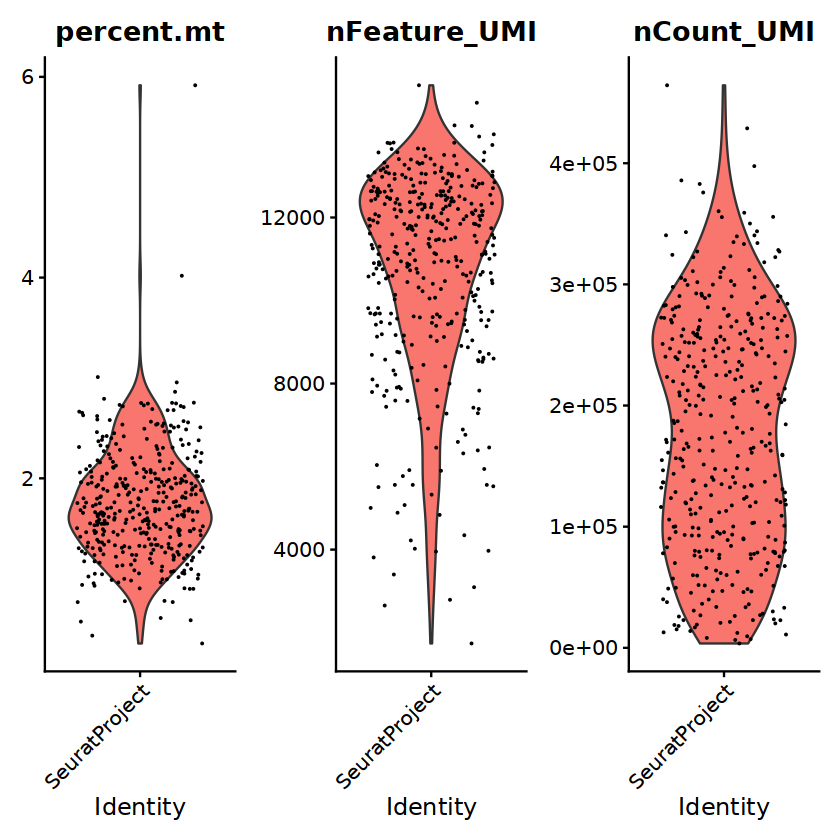

In [12]:
seurat_total <- PercentageFeatureSet(seurat_total,
                               features=filter(gene_metadata,
                                               grepl("^mt",
                                                     gene_metadata$SYMBOL),
                                               gene_metadata$GENEID %in% rownames(all_exon_umicount))$GENEID,
                               col.name = "percent.mt")
VlnPlot(seurat_total,
        c("percent.mt",
          "nFeature_UMI",
          "nCount_UMI"))

An object of class Seurat 
33969 features across 349 samples within 1 assay 
Active assay: UMI (33969 features, 0 variable features)

Warning message:
"Removed 62 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 62 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 62 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 62 rows containing missing values (`geom_point()`)."


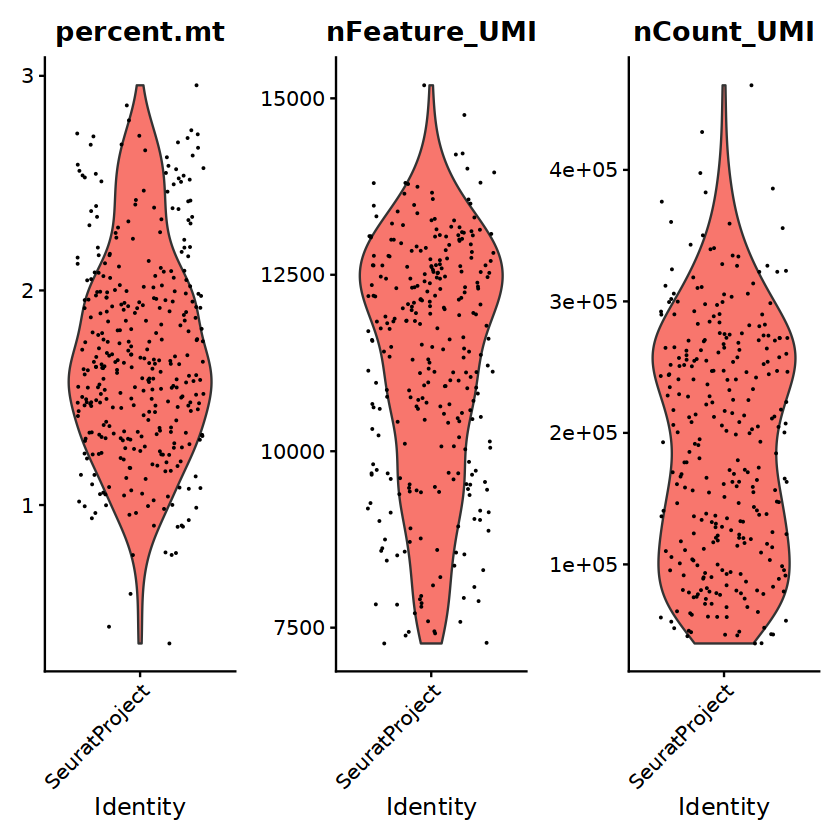

In [13]:
seurat_filt <- subset(seurat_total, 
                      percent.mt < 3 & nFeature_UMI > 7000 & nCount_UMI > 10000)
seurat_filt
VlnPlot(seurat_filt, 
        c("percent.mt", 
          "nFeature_UMI", 
          "nCount_UMI"))

In [14]:
total_melt <- seurat_filt@assays$UMI@counts %>%
    as.data.frame() %>% 
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_line=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line),
           RPK=value/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line), scaling_factor=(sum(na.omit(RPK))/1e6))) %>%
    mutate(TPM=RPK/scaling_factor)

Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Joining, by = "Well_cell_line"


In [15]:
TPM_matrix <- total_melt %>% dcast(GENEID~Well_cell_line, value.var = "TPM") %>% column_to_rownames("GENEID")

Warning message in dcast(., GENEID ~ Well_cell_line, value.var = "TPM"):
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."


In [14]:
saveRDS(seurat_filt, paste0(format(Sys.Date(), "%y%m%d"),"_nonallelic_seurat_obj.rds"))

In [22]:
write.table(TPM_matrix, paste0(format(Sys.Date(), "%y%m%d"),"_nonallelic_TPM.csv"), sep = ",")

In [6]:
XO_XX_LF_Cast_direct_UMI <- fread("XO_XX_LF_129_v22_DEEP_new_N_mask/zUMIs_output/allelic/XO_XX_LF_129_v22_DEEP_bigmem_new_N_mask.CAST_direct_UMIs.txt") %>% column_to_rownames("GeneID")
XO_XX_LF_129_direct_UMI <- fread("XO_XX_LF_129_v22_DEEP_new_N_mask/zUMIs_output/allelic/XO_XX_LF_129_v22_DEEP_bigmem_new_N_mask.BL6_direct_UMIs.txt") %>% column_to_rownames("GeneID")

In [7]:
colnames(XO_XX_LF_Cast_direct_UMI) <- all_wells %>% remove_rownames() %>% column_to_rownames("SampleID") %>% .[colnames(XO_XX_LF_Cast_direct_UMI), "Well_cell_line"]
colnames(XO_XX_LF_129_direct_UMI) <- all_wells %>% remove_rownames() %>% column_to_rownames("SampleID") %>% .[colnames(XO_XX_LF_129_direct_UMI), "Well_cell_line"]

In [8]:
XY_Cast_direct_UMI <- fread("XY_v22_DEEP_new_N_mask/zUMIs_output/allelic/XY_v22_DEEP_new_N_mask.CAST_direct_UMIs.txt") %>% column_to_rownames("GeneID")
XY_Bl6_direct_UMI <- fread("XY_v22_DEEP_new_N_mask/zUMIs_output/allelic/XY_v22_DEEP_new_N_mask.BL6_direct_UMIs.txt") %>% column_to_rownames("GeneID")

In [9]:
colnames(XY_Cast_direct_UMI) <- all_wells %>% remove_rownames() %>% column_to_rownames("SampleID") %>% .[colnames(XY_Cast_direct_UMI), "Well_cell_line"]
colnames(XY_Bl6_direct_UMI) <- all_wells %>% remove_rownames() %>% column_to_rownames("SampleID") %>% .[colnames(XY_Bl6_direct_UMI), "Well_cell_line"]

In [10]:
all_Cast_direct_UMI <- full_join(rownames_to_column(XY_Cast_direct_UMI, "GeneID"), rownames_to_column(XO_XX_LF_Cast_direct_UMI, "GeneID")) %>% remove_rownames() %>% column_to_rownames("GeneID")
all_ref_direct_UMI <- full_join(rownames_to_column(XY_Bl6_direct_UMI, "GeneID"), rownames_to_column(XO_XX_LF_129_direct_UMI, "GeneID")) %>% remove_rownames() %>% column_to_rownames("GeneID")

Joining, by = "GeneID"
Joining, by = "GeneID"


In [11]:
seurat_Cast <- CreateSeuratObject(counts = all_Cast_direct_UMI, assay = "UMI", meta.data = column_to_rownames(remove_rownames(all_wells), "Well_cell_line"), check.matrix=FALSE)
seurat_ref <- CreateSeuratObject(counts = all_ref_direct_UMI, assay = "UMI", meta.data = column_to_rownames(remove_rownames(all_wells), "Well_cell_line"), check.matrix=FALSE)

In [12]:
cast_counts <- seurat_Cast@assays$UMI@counts %>% as.data.frame()
nCountUMI_cast <- list()
nFeatureUMI_cast <- list()
for(col in colnames(cast_counts)){
    nCountUMI_cast[[col]] <- cast_counts[,col] %>% na.omit() %>% sum()
    nFeatureUMI_cast[[col]] <- cast_counts[,col] %>% na.omit() %>% .[which(. > 0)] %>% length
}

mus_counts <- seurat_ref@assays$UMI@counts %>% as.data.frame()
nCountUMI_mus <- list()
nFeatureUMI_mus <- list()
for(col in colnames(mus_counts)){
    nCountUMI_mus[[col]] <- mus_counts[,col] %>% na.omit() %>% sum()
    nFeatureUMI_mus[[col]] <- mus_counts[,col] %>% na.omit() %>% .[which(. > 0)] %>% length
}

In [13]:
seurat_Cast <- AddMetaData(seurat_Cast, unlist(nCountUMI_cast), col.name = "nCount_UMI")
seurat_Cast <- AddMetaData(seurat_Cast, unlist(nFeatureUMI_cast), col.name = "nFeature_UMI")

seurat_ref <- AddMetaData(seurat_ref, unlist(nCountUMI_mus), col.name = "nCount_UMI")
seurat_ref <- AddMetaData(seurat_ref, unlist(nFeatureUMI_mus), col.name = "nFeature_UMI")
seurat_Cast@meta.data %>% head(2)
seurat_ref@meta.data %>% head(2)

,orig.ident,nCount_UMI,nFeature_UMI,Well,SampleID,Cell_line
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
J9_XY,SeuratProject,30164,5493,J9,ACCAATCGGTAAGGACCT,XY
F9_XY,SeuratProject,49482,6935,F9,ACCAATCGGTAAGTCACC,XY


,orig.ident,nCount_UMI,nFeature_UMI,Well,SampleID,Cell_line
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
J9_XY,SeuratProject,32205,5697,J9,ACCAATCGGTAAGGACCT,XY
F9_XY,SeuratProject,52120,7156,F9,ACCAATCGGTAAGTCACC,XY


In [14]:
seurat_Cast <- seurat_Cast %>% subset(nCount_UMI > 10000)
seurat_ref <- seurat_ref %>% subset(nCount_UMI > 10000)
seurat_Cast@meta.data$in_ref <- "FALSE"
seurat_Cast@meta.data[which(rownames(seurat_Cast@meta.data) %in% rownames(seurat_ref@meta.data)),"in_ref"] <- "TRUE"
seurat_ref@meta.data$in_cast <- "FALSE"
seurat_ref@meta.data[which(rownames(seurat_ref@meta.data) %in% rownames(seurat_Cast@meta.data)),"in_cast"] <- "TRUE"
seurat_Cast <- seurat_Cast %>% subset(in_ref=="TRUE")
seurat_ref <- seurat_ref %>% subset(in_cast=="TRUE")

In [15]:
cast_melt <- seurat_Cast@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Cast=value)

mus_melt <- seurat_ref@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Mus=value)

Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error."
Joining, by = "GENEID"
Warning message in melt(., id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.

In [16]:
counts_melt <- left_join(cast_melt, mus_melt) %>% 
    mutate(total_counts=Cast+Mus) %>%
    mutate(RPK_total=total_counts/GENELENGTH,
           RPK_cast=Cast/GENELENGTH,
           RPK_mus=Mus/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line),
                        scaling_factor_total=(sum(na.omit(RPK_total))/1e6),
                        scaling_factor_cast=(sum(na.omit(RPK_cast))/1e6),
                        scaling_factor_mus=(sum(na.omit(RPK_mus))/1e6))) %>%
    mutate(TPM_total=RPK_total/scaling_factor_total,
           TPM_cast=RPK_cast/scaling_factor_total,
           TPM_mus=RPK_mus/scaling_factor_total)

counts_melt %>% head

Joining, by = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"


,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,Well_cell_line,Cast,Cell_type,Mus,total_counts,RPK_total,RPK_cast,RPK_mus,scaling_factor_total,scaling_factor_cast,scaling_factor_mus,TPM_total,TPM_cast,TPM_mus
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,Gnai3,108107280,108146146,chr3,38866,J9_XY,1,XY,1,2,5.145886e-05,2.572943e-05,2.572943e-05,1.136715e-05,5.834961e-06,5.532191e-06,4.5269789,2.263489,2.2634895
2,ENSMUSG00000000028,Cdc45,18780447,18811987,chr16,31540,J9_XY,0,XY,0,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
3,ENSMUSG00000000037,Scml2,161117193,161258213,chrX,141020,J9_XY,0,XY,0,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
4,ENSMUSG00000000056,Narf,121237253,121255856,chr11,18603,J9_XY,0,XY,0,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000
5,ENSMUSG00000000078,Klf6,5861489,5870393,chr13,8904,J9_XY,1,XY,1,2,2.246181e-04,1.123091e-04,1.123091e-04,1.136715e-05,5.834961e-06,5.532191e-06,19.7602834,9.880142,9.8801417
6,ENSMUSG00000000085,Scmh1,120405281,120530186,chr4,124905,J9_XY,0,XY,1,1,8.006085e-06,0.000000e+00,8.006085e-06,1.136715e-05,5.834961e-06,5.532191e-06,0.7043175,0.000000,0.7043175


In [18]:
TPM_matrix_cast <- counts_melt %>% dcast(GENEID~Well_cell_line, value.var="TPM_cast")
TPM_matrix_mus <- counts_melt %>% dcast(GENEID~Well_cell_line, value.var="TPM_mus")
TPM_matrix_total <- counts_melt %>% dcast(GENEID~Well_cell_line, value.var="TPM_total")

Warning message in dcast(., GENEID ~ Well_cell_line, value.var = "TPM_cast"):
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."
Warning message in dcast(., GENEID ~ Well_cell_line, value.var = "TPM_mus"):
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error."
Warning message in dcast(., GENEID ~ Well_cell_line, value.var = "TPM_total"):
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please 

In [17]:
saveRDS(seurat_Cast, paste0(format(Sys.Date(), "%y%m%d"),"_Cast_seurat_obj.rds"))
saveRDS(seurat_ref, paste0(format(Sys.Date(), "%y%m%d"),"_Mus_seurat_obj.rds"))

In [19]:
write.table(TPM_matrix_cast, paste0(format(Sys.Date(), "%y%m%d"),"_allelic_TPM_Cast.csv"), sep = ",")
write.table(TPM_matrix_mus, paste0(format(Sys.Date(), "%y%m%d"),"_allelic_TPM_Mus.csv"), sep = ",")
write.table(TPM_matrix_total, paste0(format(Sys.Date(), "%y%m%d"),"_allelic_TPM_total.csv"), sep = ",")